# Cargar las Librerías

In [1]:
import pandas as pd
import time
import functools
import matplotlib.pyplot as plt
import seaborn as sns
import logging

In [2]:
def measure_time(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Tiempo de ejecución de {func.__name__}: {end_time - start_time:.2f} segundos")
        return result
    return wrapper

# ETL

In [3]:
@measure_time
def extract(url):
    try:
        data = pd.read_csv(url)
        logging.info("Data extracted successfully.")
        return data
    except Exception as e:
        logging.error(f"Failed to extract data: {e}")
        raise

In [4]:
url = 'https://raw.githubusercontent.com/lgperrin/UPM-Modules/main/TFG-lgperrin/dataset/electronic-card-transactions-october-2023-csv-tables.csv'
data = extract(url)
data.head()

Tiempo de ejecución de extract: 2.57 segundos


,Series_reference,Period,Data_value,Suppressed,STATUS,UNITS,Magnitude,Subject,Group,Series_title_1,Series_title_2,Series_title_3,Series_title_4,Series_title_5
0,ECTA.S19A1,2001.03,2462.5,NaN,F,Dollars,6,Electronic Card Transactions (ANZSIC06) - ECT,Total values - Electronic card transactions A/...,Actual,RTS total industries,NaN,NaN,NaN
1,ECTA.S19A1,2002.03,17177.2,NaN,F,Dollars,6,Electronic Card Transactions (ANZSIC06) - ECT,Total values - Electronic card transactions A/...,Actual,RTS total industries,NaN,NaN,NaN
2,ECTA.S19A1,2003.03,22530.5,NaN,F,Dollars,6,Electronic Card Transactions (ANZSIC06) - ECT,Total values - Electronic card transactions A/...,Actual,RTS total industries,NaN,NaN,NaN
3,ECTA.S19A1,2004.03,28005.1,NaN,F,Dollars,6,Electronic Card Transactions (ANZSIC06) - ECT,Total values - Electronic card transactions A/...,Actual,RTS total industries,NaN,NaN,NaN
4,ECTA.S19A1,2005.03,30629.6,NaN,F,Dollars,6,Electronic Card Transactions (ANZSIC06) - ECT,Total values - Electronic card transactions A/...,Actual,RTS total industries,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19961 entries, 0 to 19960
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Series_reference  19961 non-null  object 
 1   Period            19961 non-null  float64
 2   Data_value        18014 non-null  float64
 3   Suppressed        826 non-null    object 
 4   STATUS            19961 non-null  object 
 5   UNITS             19961 non-null  object 
 6   Magnitude         19961 non-null  int64  
 7   Subject           19961 non-null  object 
 8   Group             19961 non-null  object 
 9   Series_title_1    19961 non-null  object 
 10  Series_title_2    19961 non-null  object 
 11  Series_title_3    3919 non-null   object 
 12  Series_title_4    0 non-null      float64
 13  Series_title_5    0 non-null      float64
dtypes: float64(4), int64(1), object(9)
memory usage: 2.1+ MB


In [6]:
data.describe()

,Period,Data_value,Magnitude,Series_title_4,Series_title_5
count,19961.00000,1.801400e+04,19961.000000,0.0,0.0
mean,2012.16173,1.649927e+07,4.214819,NaN,NaN
std,6.49508,8.927721e+07,2.743099,NaN,NaN
min,2000.01000,-5.130000e+01,0.000000,NaN,NaN
25%,2007.02000,1.774250e+02,0.000000,NaN,NaN
50%,2012.08000,1.214400e+03,6.000000,NaN,NaN
75%,2018.03000,4.430175e+03,6.000000,NaN,NaN
max,2023.10000,1.912408e+09,6.000000,NaN,NaN


In [7]:
# Contar valores nulos
null_counts = data.isnull().sum()
null_counts

Series_reference        0
Period                  0
Data_value           1947
Suppressed          19135
STATUS                  0
UNITS                   0
Magnitude               0
Subject                 0
Group                   0
Series_title_1          0
Series_title_2          0
Series_title_3      16042
Series_title_4      19961
Series_title_5      19961
dtype: int64

In [8]:
data.shape

(19961, 14)

In [9]:
@measure_time
def clean_dates(df):
    df['Year'] = df['Period'].apply(lambda x: int(x // 1))
    df['Month'] = df['Period'].apply(lambda x: int((x % 1) * 100))
    return df

In [10]:
@measure_time
def crear_columna(data, key, value_column, new_column_name):
    """
    Agrega una nueva columna al DataFrame que contiene la suma de 'value_column'
    agrupados por 'clave' usando el método de transformación para alinear las sumas con el DataFrame original.
    """
    data[new_column_name] = data.groupby(key)[value_column].transform('sum')
    return data

In [11]:
@measure_time
def transform(data):
    # Prescindir de columnas "innecesarias"
    data = data.drop(columns=['Suppressed', 'Series_title_3', 'Series_title_4', 'Series_title_5'], errors='ignore')
    
    # Formatear datos de fecha
    data['Year'] = data['Period'].apply(lambda x: int(x // 1))
    data['Month'] = data['Period'].apply(lambda x: int((x % 1) * 100))
    
    # Crear nueva columna 'Total_Transactions_Year' al sumar 'Data_value' agrupado por 'Year'
    data = crear_columna(data, 'Year', 'Data_value', 'Total_Transactions_Year')
    
    # Convertir columnas categóricas a variables dummy
    data = pd.get_dummies(data, columns=['STATUS', 'UNITS'])
    
    logging.info("Data transformed successfully.")
    return data

In [12]:
# Transformar (T)
transformed_data = transform(data)

Tiempo de ejecución de crear_columna: 0.00 segundos
Tiempo de ejecución de transform: 0.04 segundos


In [13]:
transformed_data.head()

,Series_reference,Period,Data_value,Magnitude,Subject,Group,Series_title_1,Series_title_2,Year,Month,Total_Transactions_Year,STATUS_C,STATUS_F,STATUS_P,STATUS_R,UNITS_Dollars,UNITS_Number,UNITS_Percent
0,ECTA.S19A1,2001.03,2462.5,6,Electronic Card Transactions (ANZSIC06) - ECT,Total values - Electronic card transactions A/...,Actual,RTS total industries,2001,2,2.462500e+03,False,True,False,False,True,False,False
1,ECTA.S19A1,2002.03,17177.2,6,Electronic Card Transactions (ANZSIC06) - ECT,Total values - Electronic card transactions A/...,Actual,RTS total industries,2002,2,1.196667e+09,False,True,False,False,True,False,False
2,ECTA.S19A1,2003.03,22530.5,6,Electronic Card Transactions (ANZSIC06) - ECT,Total values - Electronic card transactions A/...,Actual,RTS total industries,2003,2,4.778191e+09,False,True,False,False,True,False,False
3,ECTA.S19A1,2004.03,28005.1,6,Electronic Card Transactions (ANZSIC06) - ECT,Total values - Electronic card transactions A/...,Actual,RTS total industries,2004,2,7.733823e+09,False,True,False,False,True,False,False
4,ECTA.S19A1,2005.03,30629.6,6,Electronic Card Transactions (ANZSIC06) - ECT,Total values - Electronic card transactions A/...,Actual,RTS total industries,2005,2,8.466119e+09,False,True,False,False,True,False,False


c:\Users\dellw\anaconda3\envs\LUNA\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


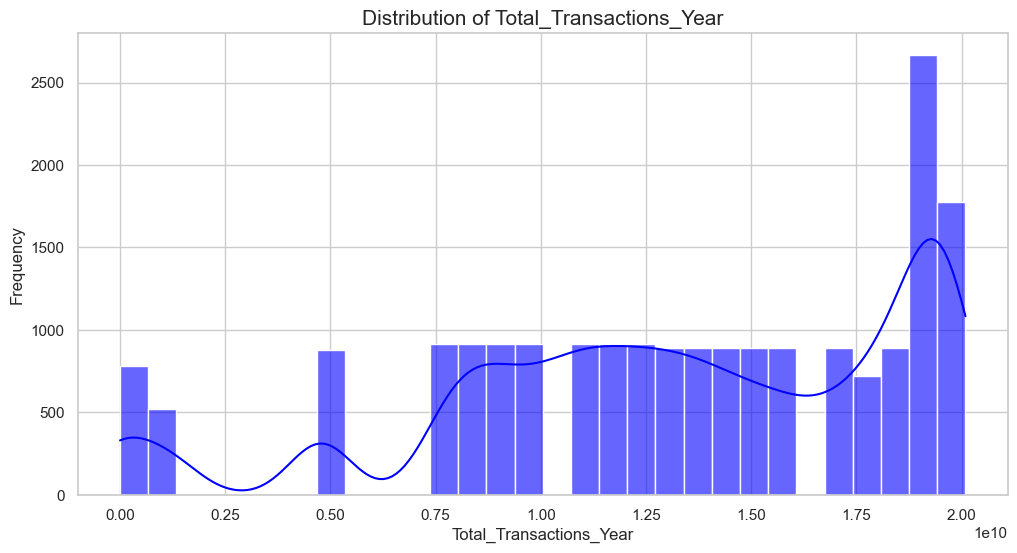

In [16]:
# Set the aesthetic style of the plots
column_name = "Total_Transactions_Year"

# Create a figure with specified size
plt.figure(figsize=(12, 6))

# Create a histogram with a kernel density estimate
sns.histplot(transformed_data[column_name], kde=True, color="blue", bins=30, alpha=0.6)

# Adding title and labels
plt.title(f'Distribution of {column_name}', fontsize=15)
plt.xlabel(column_name, fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.show()

In [ ]:
# Para guardar los datos en nuestra BBDD
pip install sqlalchemy psycopg2

from sqlalchemy import create_engine

@measure_time
def store_data(data, table_name, db_details):
    """Store the DataFrame into a PostgreSQL table."""
    engine = create_engine(f'postgresql://{db_details["user"]}:{db_details["password"]}@{db_details["host"]}:{db_details["port"]}/{db_details["dbname"]}')
    data.to_sql(table_name, con=engine, if_exists='replace', index=False)
    print(f"Data stored in PostgreSQL table '{table_name}' successfully.")

# Database details
db_details = {
    'user': 'your_username',
    'password': 'your_password',
    'host': 'localhost',
    'port': 5432,
    'dbname': 'your_database'
}

# Example usage
store_data(data, 'your_table_name', db_details)